### 客户价值分析

**1、项目概述**  


随着行业竞争愈加激烈，商家更多的运营思路转向客户，客户是企业生存的关键，客户需求是客户消费的直接原因，那么，企业如何细分客户？如何确定哪些是重要客户、发展客户、潜在客户？  


根据客户历史消费记录，分析不同客户群体的特征与价值，针对不同客户群体定制不同的营销策略，尤为重要。  


**项目分析方法：RFM模型、聚类分析、可视化图表**  

**2、实现过程**  


RFM模型是衡量客户价值和客户创造利益能力的重要工具和手段，是目前最成熟、最为容易的客户价值分析方法，包括三个指标：  


R:最近消费时间间隔Recency，值越小，价值越大；  
F:消费频率Frequency，值越大，价值越大;  
M：消费金额Monetary，值越大，价值越大。  


**第一步，数据读取和导入，并进行数据预处理。包括抽取特定数据，进行合并和输出；缺失值处理。**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# 设置字体为黑体大小为11
plt.rc('font', family='SimHei', size=11)
matplotlib.rcParams['axes.unicode_minus'] = False
pd.set_option('display.unicode.east_asian_width', True)

# 取消显示未来警告问题
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# 合并数据
df_2018 = pd.read_excel('data/2018.xlsx')
df_2019 = pd.read_excel('data/2019.xlsx')
df_2018 = df_2018[['买家会员名', '买家实际支付金额', '订单付款时间']]
df_2019 = df_2019[['买家会员名', '买家实际支付金额', '订单付款时间']]

# 如果数据之间没有明确的关联，只是简单的堆叠：用concat。
# 如果数据之间有逻辑关系，需要基于键进行合并：用merge。
dfs = pd.concat([df_2018, df_2019])
dfs.to_excel('./data/all.xlsx', index=False)

dfs.head()

,买家会员名,买家实际支付金额,订单付款时间
0,mr0932,748.50,2018-01-01 09:26:18
1,mr0121,90.00,2018-01-01 10:06:07
2,mr0932,10.00,2018-01-01 10:06:48
3,mr0863,269.00,2018-01-01 10:18:12
4,mr0356,50.86,2018-01-01 16:08:22


In [3]:
# 数据清洗
data = pd.read_excel('data/all.xlsx')
# include='all' 包含所有数值都进行运算
view = data.describe(percentiles=[], include='all').T  # percentiles=[] 传入了一个空列表 []，表示不计算任何百分位数。
view


,count,unique,top,freq,mean,min,50%,max,std
买家会员名,3908,3167,mr2029,14,NaN,NaN,NaN,NaN,NaN
买家实际支付金额,3908.0,NaN,NaN,NaN,111.428613,0.0,51.87,25332.97,505.72447
订单付款时间,3271,NaN,NaN,NaN,2019-01-26 09:19:57.875573248,2018-01-01 09:26:18,2019-02-21 15:18:23,2019-12-31 20:33:54,NaN


In [4]:
# 每列缺失值的个数
print(data.isna().astype(int).sum())
# 生成一个空值数最大值最小值的excel表格
view['null'] = len(data) - view['count']
view = view[['null', 'max', 'min']]

# 重置表头
view.columns = ['空值数', '最大值', '最小值']
view.to_excel('data/result.xlsx')
view

买家会员名            0
买家实际支付金额      0
订单付款时间        637
dtype: int64


,空值数,最大值,最小值
买家会员名,0,NaN,NaN
买家实际支付金额,0.0,25332.97,0.0
订单付款时间,637,2019-12-31 20:33:54,2018-01-01 09:26:18


**第二步，计算RFM值并进行数据转换。**    


首先，去除 **"订单付款时间"** 为空值和 **"买家实际支付金额"** 为0的数据;  
然后，计算RFM值，**R值为最近一次消费时间与某时刻时间（如2019-12-31）间隔，本表中最后一天是2019年12月31日，只需要与这个时间做差即可。F值为客户累计消费次数，M值为客户累计消费金额。** 


**【关键技术】**  


复制数据copy()、分组groupby()、聚合agg()、时间差计算timedelta64()、均值mean()、标准差std()。

In [5]:
data_all = pd.read_excel('data/all.xlsx')
# 去除空值、订单付款时间非空才保留
# 去除买家实际支付金额为0的记录
data_1 = data_all[data_all['订单付款时间'].notnull() & data_all['买家实际支付金额'] != 0]
print(data_1.isna().astype(int).sum())
data_1.head()

买家会员名          0
买家实际支付金额    0
订单付款时间        0
dtype: int64


,买家会员名,买家实际支付金额,订单付款时间
0,mr0932,748.50,2018-01-01 09:26:18
1,mr0121,90.00,2018-01-01 10:06:07
2,mr0932,10.00,2018-01-01 10:06:48
3,mr0863,269.00,2018-01-01 10:18:12
4,mr0356,50.86,2018-01-01 16:08:22


In [6]:
data = data_1.copy()
# R N F
# 两个日期相减得到的是一个Timedelta 对象的 Series
# pd.to_datetime 将时间转化为 timedelta64
# .values是将时间差的 Series 转化为 np 数组,此时数据类型仍为 timedelta64,方便后期计算
# round方法四舍五入
data['最近消费时间间隔'] = ((pd.to_datetime('2020-01-01') - pd.to_datetime(data['订单付款时间'])).values / np.timedelta64(1, 'D')).round()
data.head()

,买家会员名,买家实际支付金额,订单付款时间,最近消费时间间隔
0,mr0932,748.50,2018-01-01 09:26:18,730.0
1,mr0121,90.00,2018-01-01 10:06:07,730.0
2,mr0932,10.00,2018-01-01 10:06:48,730.0
3,mr0863,269.00,2018-01-01 10:18:12,730.0
4,mr0356,50.86,2018-01-01 16:08:22,729.0


In [7]:
# 重新规整列名
df = data[['订单付款时间', '买家会员名', '买家实际支付金额', '最近消费时间间隔']]
df.head()

,订单付款时间,买家会员名,买家实际支付金额,最近消费时间间隔
0,2018-01-01 09:26:18,mr0932,748.50,730.0
1,2018-01-01 10:06:07,mr0121,90.00,730.0
2,2018-01-01 10:06:48,mr0932,10.00,730.0
3,2018-01-01 10:18:12,mr0863,269.00,730.0
4,2018-01-01 16:08:22,mr0356,50.86,729.0


In [8]:
# size 聚合函数，用于计算 每个分组中的元素个数（即该会员的订单数量）。
df_g_user = df.groupby('买家会员名').agg({'买家会员名': 'size',
                                         '最近消费时间间隔': 'min',
                                         '买家实际支付金额': 'sum'})
df_g_user.head()

,买家会员名,最近消费时间间隔,买家实际支付金额
买家会员名,,,
mr0001,1,6.0,14.90
mr0002,1,42.0,51.87
mr0003,1,302.0,178.68
mr0004,1,41.0,65.40
mr0005,2,448.0,411.50


In [9]:
df2 = df_g_user.rename(columns={'买家会员名': '消费频率',
                          '买家实际支付金额': '消费金额'})
df2.head()

,消费频率,最近消费时间间隔,消费金额
买家会员名,,,
mr0001,1,6.0,14.90
mr0002,1,42.0,51.87
mr0003,1,302.0,178.68
mr0004,1,41.0,65.40
mr0005,2,448.0,411.50


In [10]:
# 数据格式转换
# 提取指定列的数据
data = df2[['最近消费时间间隔', '消费频率', '消费金额']]
# 标准化处理  消除不同列之间的量纲差异，使数据在同一尺度上,加速梯度下降
# mean计算每一列的均值 , std计算标准差, axis=0 按行对列进行求
# 先计算出每一列的平均值，然后用原数据减去该平均值,最后除以每列的标准差,最后就是标准化后的结果
data = (data - data.mean(axis=0)) / (data.std(axis=0))
# 表头重命名
data.columns = ['R', 'F', 'M']
# 导出现有结果
df2.to_excel('data/RFM.xlsx')
data.to_excel('data/transformdata.xlsx', index=False)
data.head()

,R,F,M
买家会员名,,,
mr0001,-1.392741,-0.349334,-0.220797
mr0002,-1.237763,-0.349334,-0.168030
mr0003,-0.118471,-0.349334,0.012967
mr0004,-1.242068,-0.349334,-0.148718
mr0005,0.510054,0.976162,0.345271


**第三步，KMeans聚类分析，绘制密度图可视化，导出数据，标记客户类别、根据类别统计客户RFM值，最后进行结果分析。**  


**【关键技术】**


聚类分析KMeans( )、绘制密度图plot(kind='kde'）

In [11]:
data = pd.read_excel('data/transformdata.xlsx')
# 聚类
k = 4
kmodel = KMeans(n_clusters=k)
kmodel.fit(data)

# kmodel.labels_：这是 KMeans 或类似聚类模型中的标签数组，每个元素代表对应样本所属的聚类编号。
# pd.Series(kmodel.labels_)：将标签数组转为 Pandas Series。
# value_counts()：统计每个标签的出现次数，即每个聚类中的样本数量。
r1 = pd.Series(kmodel.labels_).value_counts()  # 统计每个聚类标签中样本的数量

# kmodel.cluster_centers_：这是一个 NumPy 数组，其中包含每个聚类中心的坐标。
# 如果模型是基于二维数据的，每个中心点会有两个坐标值；
# 如果是高维数据，每个中心点会有对应维度的坐标。
r2 = pd.DataFrame(kmodel.cluster_centers_)  # 将聚类中心点的数据转换为 df 以便进一步分析。

# r1：统计每个聚类中的样本数量，结果是一个 Series，键是聚类编号，值是对应的样本数量。
# r2：将聚类中心的坐标转换为 DataFrame，每行代表一个聚类中心的坐标。
print(r1)
r2

1    1316
0     978
3     120
2       3
Name: count, dtype: int64


,0,1,2
0,1.013352,-0.147393,-0.018006
1,-0.739528,-0.215375,-0.088156
2,0.045118,2.743489,24.698081
3,-0.149790,3.494604,0.496072


**r2 中每一行代表一个聚类中心的坐标：**  


每个聚类中心是一个点，其维度（列）数量与数据的特征数一致。  


**有 3 个特征（列 0, 1, 2）-> （R、F、M）**   


每个聚类的中心点是所有属于该聚类样本的 特征均值。  
例如：  

 
聚类 0 的中心：[-0.149790, 3.494604, 0.496072]  
这意味着所有属于聚类 0 的样本，其在特征 0、1、2 上的均值分别为 -0.149790、3.494604、0.496072。  

In [12]:
# 数据合并
r = pd.concat([r2, r1], axis=1)  # r2、r1有相同的索引,所以[r2, r1]是将r1追加到r2后面
                                 # 并将 data 的列名加上一列 '聚类数量' 作为r1的列名
r.columns = list(data.columns) + ['聚类数量']  # 
r

,R,F,M,聚类数量
0,1.013352,-0.147393,-0.018006,978
1,-0.739528,-0.215375,-0.088156,1316
2,0.045118,2.743489,24.698081,3
3,-0.149790,3.494604,0.496072,120


In [13]:
# 类别标记
# 将 KMeans 模型生成的聚类标签与原始数据的 索引 对应。
# kmodel.labels_：这是模型生成的聚类标签数组，每个标签对应一个样本的聚类类别。
# index=data.index：这里的 index 参数是给 pd.Series() 赋值的标签索引，使每个聚类标签与原始数据中的样本 一一对应。
r3 = pd.Series(kmodel.labels_, index=data.index)
r3

0       1
1       1
2       1
3       1
4       0
       ..
2412    0
2413    0
2414    1
2415    1
2416    0
Length: 2417, dtype: int32

In [14]:
r = pd.concat([data, r3], axis=1)  # 将data与r3合并他们有共同的列名
r.columns = list(data.columns) + ['聚类类别']  # data + '聚类类别' 作为新DF的列名
r.to_excel('data/type.xlsx')
r

,R,F,M,聚类类别
0,-1.392741,-0.349334,-0.220797,1
1,-1.237763,-0.349334,-0.168030,1
2,-0.118471,-0.349334,0.012967,1
3,-1.242068,-0.349334,-0.148718,1
4,0.510054,0.976162,0.345271,0
...,...,...,...,...
2412,1.289253,-0.349334,1.567756,0
2413,1.241898,-0.349334,-0.182317,0
2414,0.079557,-0.349334,0.026269,1
2415,-1.358302,-0.349334,-0.173725,1


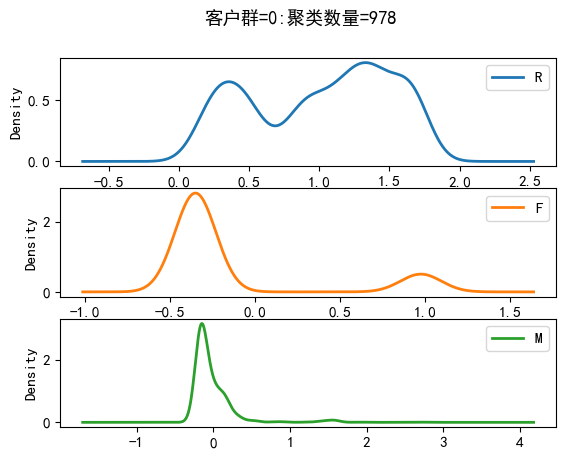

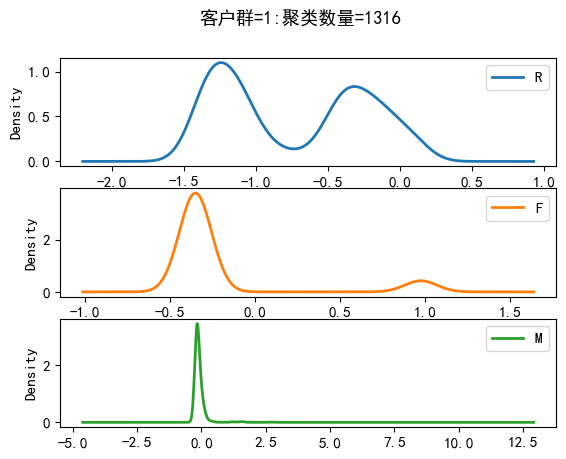

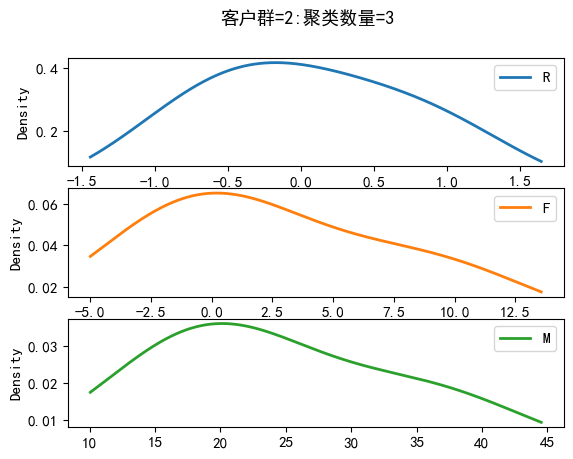

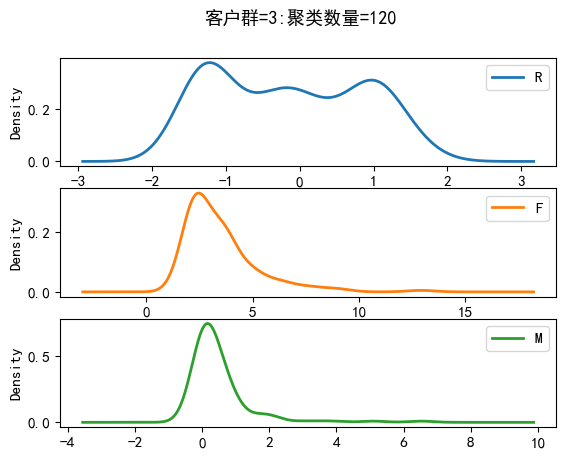

In [15]:
# 对每个聚类的样本数据进行核密度估计（KDE）绘图,并为每个聚类生成单独的图表
for i in range(k):  # 分为 4 类
    # 布尔索引操作，选择DF中 r 中聚类类别为第i类的数据行。从data原始数据中提取出属于第 i 类的数据
    cls = data[r['聚类类别'] == i]  
    # kind='kde'：使用 核密度估计（KDE）方式绘制样本分布图，显示每个特征的概率密度分布。
    # linewidth=2：设置线条宽度为 2，subplots=True：为每个特征绘制单独的子图。每一列（特征）都会生成一幅 KDE 图。
    # sharex=False：每个子图的 x 轴不共享，允许每个特征有自己的 x 轴范围。
    cls.plot(kind='kde', linewidth=2, subplots=True, sharex=False)
    # plt.suptitle(...)：为整个子图布局添加一个 标题。
    # 将当前的 聚类编号（i） 和对应的 聚类数量（r1[i]） 填入标题
    plt.suptitle('客户群=%d:聚类数量=%d' % (i, r1[i]))

plt.show()

R:最近消费时间间隔Recency，值越小，价值越大；  
F:消费频率Frequency，值越大，价值越大;  
M：消费金额Monetary，值越大，价值越大。  

In [16]:
cdata = pd.read_excel('data/RFM.xlsx')
cdata.head()

,买家会员名,消费频率,最近消费时间间隔,消费金额
0,mr0001,1,6,14.90
1,mr0002,1,42,51.87
2,mr0003,1,302,178.68
3,mr0004,1,41,65.40
4,mr0005,2,448,411.50


In [17]:
# 提取特定列
cdata = cdata[['买家会员名', '最近消费时间间隔', '消费频率', '消费金额']]
cdata.head()

,买家会员名,最近消费时间间隔,消费频率,消费金额
0,mr0001,6,1,14.90
1,mr0002,42,1,51.87
2,mr0003,302,1,178.68
3,mr0004,41,1,65.40
4,mr0005,448,2,411.50


In [18]:
# 标记原始数据类别,将 K-mean聚的类标签添加到cdata的最后一列
cdata = pd.concat(
    [cdata, pd.Series(kmodel.labels_, index=cdata.index)], axis=1
)
cdata.head()

,买家会员名,最近消费时间间隔,消费频率,消费金额,0
0,mr0001,6,1,14.90,1
1,mr0002,42,1,51.87,1
2,mr0003,302,1,178.68,1
3,mr0004,41,1,65.40,1
4,mr0005,448,2,411.50,0


In [19]:
# 重命名各列及最后一列
cdata.columns = ['买家会员名', 'R-最近消费时间间隔', 'F-消费频率', 'M-消费金额', '类别']
cdata.to_excel('data/client.xlsx')
cdata.head()

,买家会员名,R-最近消费时间间隔,F-消费频率,M-消费金额,类别
0,mr0001,6,1,14.90,1
1,mr0002,42,1,51.87,1
2,mr0003,302,1,178.68,1
3,mr0004,41,1,65.40,1
4,mr0005,448,2,411.50,0


In [20]:
cdata.dtypes

买家会员名             object
R-最近消费时间间隔      int64
F-消费频率              int64
M-消费金额            float64
类别                    int32
dtype: object

In [21]:
# 按照类别分组统计R、F、M的指标均值
# 但是买家会员名是object对象无法求平均值
data_mean = cdata.groupby(['类别']).mean()
data_mean.head()

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
data_mean_data = cdata.drop(['买家会员名'], axis=1)
data_mean_data.head()

In [ ]:
data_mean = data_mean_data.groupby('类别').mean()
data_mean.to_excel('data/client_mean.xlsx')
data_mean

In [ ]:
# 增加一行RFM平均值(忽略索引),根据求出的平均值判断RFM的高低
new = data_mean.mean()
new

In [ ]:
# 插入到最后
df = data_mean
df.loc['RFM均值'] = new
df

**3.客户价值结果分析。**  


首先，客户分类依据是：  


**潜在客户：R、F、M值低，这类客户短时间内消费过，消费次数和金额较少。
可以采取密集的营销信息推送，增加消费次数和金额。**  

**<font color = red>一般发展客户：R值高、F、M低，这类客户很长时间没有消费了，次数和金额也较少，可能只会在打折促销时消费。</font>**


<mark>一般保持客户：F高，消费次数多，是忠实客户，应多传递各类促销和新品信息等。<mark>    

**<mark style=background-color:y>重要保持客户：F、M高，R略高于平均值，是高价值客户，对品牌、产品认可度高，贡献值大。</mark>** 


<mark><font color=red size=4 face=雅黑>df的输出结果的第五行是RFM各值的均值，可以发现，客户群2是潜在客户、客户群0是一般发展客户、客户群3是一般保持客户、客户群1是重要保持客户。<font><mark>


![jupyter](1.png)

concat：  

主要用于堆叠数据，按行或列简单拼接。  
数据之间不需要有主键关系。  
拼接方向通过axis控制。  


merge：  

类似于SQL的连接操作，用于按键值匹配合并。  
适用于两个DataFrame之间有逻辑关系的数据。  
需要通过on或left_on/right_on指定合并键。  